## Neural Network

In this notebook, we will use sklearn's MLPClassifier to create a trading strategy using the neural network. We will
follow the below steps.

1. Import the data
2. Define predictors and target variables
3. Split the data into train and test dataset
4. Scale the data
5. Create a neural network using the train data
6. Analyze the performance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
import talib as ta
%matplotlib inline

In [2]:
quandl.connection.ApiConfig.api_key= "_N85bWLCNCWz14smKHSi"

In [29]:
data = quandl.get('WIKI/BA',start_date='2013-01-01',end_date='2018-01-01')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2013-01-02 to 2017-12-29
Data columns (total 12 columns):
Open           1258 non-null float64
High           1258 non-null float64
Low            1258 non-null float64
Close          1258 non-null float64
Volume         1258 non-null float64
Ex-Dividend    1258 non-null float64
Split Ratio    1258 non-null float64
Adj. Open      1258 non-null float64
Adj. High      1258 non-null float64
Adj. Low       1258 non-null float64
Adj. Close     1258 non-null float64
Adj. Volume    1258 non-null float64
dtypes: float64(12)
memory usage: 127.8 KB


In [31]:
data.describe()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.0,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,144.413480,145.572240,143.327940,144.516391,4.216394e+06,0.014738,1.0,136.194755,137.286279,135.174549,136.293179,4.216394e+06
std,43.121667,43.396857,42.916789,43.170806,2.558999e+06,0.122717,0.0,45.959822,46.263372,45.732245,46.015548,2.558999e+06
min,72.780000,74.240000,72.680000,73.650000,7.889450e+05,0.000000,1.0,63.963546,65.246683,63.875659,64.728155,7.889450e+05
25%,125.297500,126.252575,124.162500,125.430000,2.867656e+06,0.000000,1.0,114.573501,115.729188,113.777855,114.670631,2.867656e+06
50%,133.170000,134.115000,132.187800,133.020000,3.684468e+06,0.000000,1.0,124.955384,125.945348,123.821701,124.897337,3.684468e+06
75%,149.837500,150.825000,148.985000,149.907500,4.803825e+06,0.000000,1.0,140.446357,141.364925,139.437778,140.525896,4.803825e+06
max,298.880000,299.330000,297.110000,297.900000,4.439180e+07,1.420000,1.0,298.880000,299.330000,297.110000,297.900000,4.439180e+07


# Define predictor variables and a target variable

We define a list of predictors as listed below 
1. ret1 is the one-day returns, 
2. ret5 is the five-day returns, 
3. std5 is the five-day standard deviation, 
4. volume_by_adv20 is the volume divided by the 20-days average of daily volume and 
5. price differences (High - Low) and (Open - Close). <BR>

Syntax:
1. <font color='blue'>pct_change()</font> computes the percentage change from the immediately previous row by default.
2. <font color='blue'>rolling_sum(dataframe.column_name, window=n)</font> computes the sum of previous n rows.
3. <font color='blue'>rolling_std(dataframe.column_name, window=n)</font> computes the standard deviation of previous n rows.

In [32]:
# Returns
data['ret1'] = data['Adj. Close'].pct_change()

In [33]:
# Returns

data['ret5'] = data['ret1'].rolling(5).sum()

# Standard Deviation
data['std5'] = data['ret1'].rolling(5).std()

# Volume by ADV20
data['volume_by_adv20'] = data['Adj. Volume']/data['Adj. Volume'].rolling(20).mean()

# High - low
data['H-L'] = data['Adj. High'] - data['Adj. Low']

# Open - Close
data['O-C'] = data['Adj. Close'] - data['Adj. Open']

In [34]:
data.tail(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,ret1,ret5,std5,volume_by_adv20,H-L,O-C
Date,,,,,,,,,,,,,,,,,,
2017-12-27,296.41,296.80,294.80,295.62,1300956.0,0.0,1.0,296.41,296.80,294.80,295.62,1300956.0,0.000880,-0.005449,0.004829,0.352270,2.00,-0.79
2017-12-28,295.81,296.99,294.74,296.35,1432444.0,0.0,1.0,295.81,296.99,294.74,296.35,1432444.0,0.002469,-0.005166,0.004878,0.395731,2.25,0.54
2017-12-29,296.94,297.30,294.83,294.91,1813317.0,0.0,1.0,296.94,297.30,294.83,294.91,1813317.0,-0.004859,-0.000391,0.002797,0.521897,2.47,-2.03


We define the target variable which is the future one-day returns. <BR>

Syntax:
<font color='blue'>shift(periods=n)</font> shifts the values by n period(s). If the value of n is negative then, it shifts the values backward and vice-versa.

In [35]:
data['retFut1'] = data.ret1.shift(-1)

In [36]:
# Define predictor variables (X) and a target variable (y)
data = data.dropna()
predictor_list = ['H-L','O-C','ret5', 'std5','volume_by_adv20']
X = data[predictor_list]


y = np.where(data.retFut1 > 0.0, 1.0, 0)

In [37]:
X.head()

,H-L,O-C,ret5,std5,volume_by_adv20
Date,,,,,
2013-01-30,0.896439,0.149406,0.004320,0.012011,1.091259
2013-01-31,0.755821,-0.553683,-0.019198,0.010100,0.818021
2013-02-01,0.738244,0.333967,-0.001810,0.012743,0.712214
2013-02-04,1.124943,0.808553,0.016459,0.010346,0.604466
2013-02-05,1.204040,0.175772,0.030230,0.009473,0.713230


In [38]:
# Split the data into train and test dataset
from sklearn.model_selection import train_test_split

train_length = int(len(data)*0.80)

X_train = X[:train_length] 
X_test =  X[train_length:]

y_train = y[:train_length]
y_test = y[train_length:]    

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create the scaler model using train data
scaler.fit(X_train)

# Transform the training and test data using the scaler model created above
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Create a neural network model

The MLPClassifier function from the sklearn.neural_network package is used to create a neural network model. The MLPClassifier takes following as input parameter
1. <b>activation:</b> The activation function such as logistic regression can be used to define the output from the neurons.
2. <b>hidden_layer_sizes:</b> A tuple to specify the number of hidden layers and number of neurons in each of the hidden layers. For example, the tuple (2,5) indicates two hidden layers with 2 neurons in the first layer and 5 neurons in the second layer.
3. <b>random_state:</b> It is used to initialize the weights and bias.
4. <b>solver:</b> A function such as stochastic gradient descent is used to optimize the weights during backpropagation. 'sgd' is specified to indicate 'stochastic gradient descent'. For the full list of functions type help(MLPClassifier).

In [40]:
# Import the MLPClassifier
from sklearn.neural_network import MLPClassifier
# Uncomment below line to see details of MLPClassifier
help(MLPClassifier)

Help on class MLPClassifier in module sklearn.neural_network.multilayer_perceptron:

class MLPClassifier(BaseMultilayerPerceptron, sklearn.base.ClassifierMixin)
 |  Multi-layer Perceptron classifier.
 |  
 |  This model optimizes the log-loss function using LBFGS or stochastic
 |  gradient descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity', 'logistic', 'tanh', 'relu'}, default 'relu'
 |      Activation function for the hidden layer.
 |  
 |      - 'identity', no-op activation, useful to implement linear bottleneck,
 |        returns f(x) = x
 |  
 |      - 'logistic', the logistic sigmoid function,
 |        returns f(x) = 1 / (1 + exp(-x)).
 |  
 |      - 'tanh', the hyperbolic tan function,
 |        returns f(x) = tanh(x).
 |  
 |      - 'relu', the rectified linear u

In [41]:
# seed is initialized to 42
seed = 42
# Create the MLPClassifier model
mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=(5), random_state=seed, solver='sgd',learning_rate_init=0.01, alpha=0.001)

In [42]:
# Fit the model on train dataset
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [43]:
data.loc[:,'predicted_signal'] = mlp.predict(X)
data.loc[:,'strategy_returns_nn'] = data.loc[:,'retFut1'] * data.loc[:,'predicted_signal']
data.tail(3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,...,Adj. Volume,ret1,ret5,std5,volume_by_adv20,H-L,O-C,retFut1,predicted_signal,strategy_returns_nn
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,295.54,297.44,294.65,295.36,1392455.0,0.0,1.0,295.54,297.44,294.65,...,1392455.0,0.000881,-0.002581,0.005271,0.374088,2.79,-0.18,0.000880,0.0,0.0
2017-12-27,296.41,296.80,294.80,295.62,1300956.0,0.0,1.0,296.41,296.80,294.80,...,1300956.0,0.000880,-0.005449,0.004829,0.352270,2.00,-0.79,0.002469,0.0,0.0
2017-12-28,295.81,296.99,294.74,296.35,1432444.0,0.0,1.0,295.81,296.99,294.74,...,1432444.0,0.002469,-0.005166,0.004878,0.395731,2.25,0.54,-0.004859,0.0,-0.0


### Sharpe Ratio

The Sharpe ratio is calculated as follows:

<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/R2TAJa6K/Sharpe-1.jpg"></img>

Where
- N is the number of trading days in a year
- Rf is the risk-free rate
- Std dev is the standard deviation

Sharpe ratio represents how good the strategy performance is for the risk (standard deviation) taken to achieve it. The higher the Sharpe ratio the better is the strategy. Generally, a Sharpe ratio of greater than 1.5 is preferred.

In [44]:
# The below function returns the Sharpe ratio for the excess returns (Strategy returns - Risk free rate) passed to it.
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

In [45]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_nn - 0.05/252
sharpe_train_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length])
# Test dataset
sharpe_test_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length:])

### Strategy CAGR
CAGR represents the compounded annual returns of the strategy. The strategy CAGR is computed as follows:

<i>(Cumulative returns + 1)^(252/number of days) - 1</i>

where cumulative returns are the total strategy returns and number of days represent the total trading days.

In [46]:
def CAGR(returns):
    cumulative_returns = returns.cumsum().iloc[-1]   
    period_in_days = len(returns)
    return 100*((cumulative_returns+1)**(252.0/period_in_days)-1)

In [47]:
# CAGR
# Train dataset
ret_train_nn = CAGR(data.strategy_returns_nn.iloc[:train_length])
# Test dataset
ret_test_nn = CAGR(data.strategy_returns_nn.iloc[train_length:])

In [48]:
import matplotlib.pyplot as plt
import seaborn

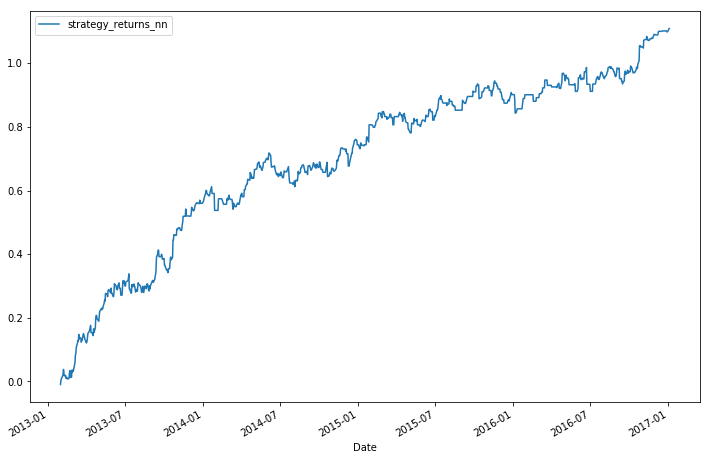

In [49]:
# Plot the cumulative returns for neural network in train dataset
data.strategy_returns_nn[:train_length].cumsum().plot(figsize=(12,8))

# Show the legend
plt.legend()

# Show the graph
plt.show()

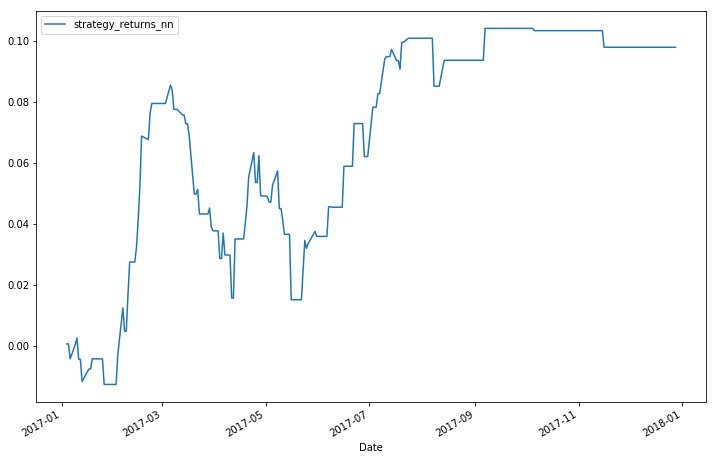

In [50]:
# Plot the cumulative returns for neural network in test dataset
data.strategy_returns_nn[train_length:].cumsum().plot(figsize=(12,8))

# Show the legend
plt.legend()

# Show the graph
plt.show()

In [51]:
from tabulate import tabulate

print(tabulate(
        [             
            ['CAGR', ret_train_nn, ret_test_nn],
            ['Sharpe Ratio', sharpe_train_nn, sharpe_test_nn],
        ], 
        headers=['Train', 'Test'], 
    tablefmt='orgtbl'))

|              |    Train |     Test |
|--------------+----------+----------|
| CAGR         | 20.9212  | 9.95118  |
| Sharpe Ratio |  1.45948 | 0.639643 |


In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test,mlp.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.41      0.33      0.37        96
        1.0       0.62      0.70      0.66       152

avg / total       0.54      0.56      0.55       248



The output of classification report
1. <B>Precision</B>: tp / (tp + fp) 
<BR>where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
2. <B>Recall</B>: tp / (tp + fn) 
<BR> where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
3. <B>F1-score</B>: It can be interpreted as a weighted harmonic mean of the precision and recall, The F1-score reaches its best value at 1 and worst score at 0. 
5. <B>Support</B>: It is the number of occurrences of each class in y_true.